In [1]:
import sys

sys.path.append('/home/max/myrepos/vlstm_cuda/')

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
import triton
import triton.language as tl
import math

In [2]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [3]:
from src_triton.mlstm_parallel_fwbw_v0.mlstm_fw import mlstm_fw
from src_triton.mlstm_parallel_fwbw_v0.torch_impl import vlstm_fw_torch_ref as mlstm_fw_torch
from src_triton.utils import lower_triangular_block_matrix
from plot_utils import plot_numerical_diffs_single

In [4]:
list(range(0,0*8,4))

[]

In [5]:
S = 256 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 512 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")
BLOCK_Q = 16
BLOCK_KV = 16

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S) / 10.
# igs = torch.zeros((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = mlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs.unsqueeze(-1), fgate_preact=fgs.unsqueeze(-1))

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = mlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half.unsqueeze(-1), fgate_preact=fgs_half.unsqueeze(-1))

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = mlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16.unsqueeze(-1), fgate_preact=fgs_bf16.unsqueeze(-1))

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 1.446578025817871
fw n match: False, max diff: 0.18470120429992676
fw m match: False, max diff: 0.1912614107131958
fw D match: False, max diff: 0.15697169303894043
====== Full -> bfloat16 ======
fw hs match: False, max diff: 8.572738647460938
fw n match: False, max diff: 1.0001626014709473
fw m match: False, max diff: 0.9422379732131958
fw D match: False, max diff: 0.5769522190093994


### compare errors triton vs pytorch

In [13]:
hs_half, m_half, n_half = mlstm_fw(matQ=qs_half, matK=ks_half, matV=vs_half, vecI=igs_half, vecF=fgs_half)#, BLOCK_Q=BLOCK_Q, BLOCK_KV=BLOCK_KV)

In [14]:
hs_half[:, :, :10, :10]

tensor([[[[-2.5449,  0.7163,  0.4934, -0.1267, -0.1014,  0.4036, -0.9023, -0.8101,  0.6885, -0.1372],
          [ 1.3594, -0.4219, -0.7080, -0.3025,  0.3933,  0.1838,  0.7090,  0.5254, -0.2505, -0.6602],
          [ 1.7988, -0.0078, -0.6157,  0.3740, -0.0610, -0.3042,  0.7271, -0.1118, -0.2529,  0.4495],
          [-0.0792, -0.4255,  1.4326, -0.8276,  0.8706,  0.0194, -1.6543,  0.3345, -1.1123, -0.0142],
          [ 1.0801, -0.1984,  1.3359, -0.5562,  0.3945,  0.1166, -0.2037,  0.6733, -0.7012, -0.3118],
          [-0.8765, -1.8057,  0.6792,  0.2568, -2.1992,  2.9551,  1.5137,  1.3369,  1.2197,  0.8149],
          [ 0.5684,  1.3135, -0.7935, -0.0248,  1.4941, -1.8896, -0.7866, -1.0293, -0.5737, -0.5547],
          [-0.6899, -1.6865,  1.1895, -0.1371, -1.6270,  3.0840,  1.4268,  1.5244,  0.9814,  0.7144],
          [ 0.8330,  0.2954,  0.8418,  0.4055, -0.1340, -0.0912,  0.7173, -0.5708, -0.5737, -0.2751],
          [-1.7539, -0.5781, -0.4910, -0.1847,  1.3115,  0.2986, -0.1704, -0.7124,

In [15]:
hs_diff = hs_half - hs_pt_half

In [16]:
hs_diff[:, :, -10:, :10], hs_diff.abs().max()

(tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [-9.7656e-04,  0.0000e+00,  6.1035e-05,  0.0000e+00,  2.4414e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00, -6.1035e-05,  0.0000e+00],
           [-2.2888e-04, -1.5259e-04,  0.0000e+00, -4.8828e-04,  0.0000e+00, -4.8828e-04, -9.7656e-04, -4.8828e-04,  2.4414e-04,  1.9531e-03],
           [-9.7656e-04,  0.0000e+00,  6.1035e-04,  1.9531e-03,  4.8828e-04,  0.0000e+00, -9.7656e-04, -6.1035e-04,  6.1035e-05,  6.1035e-04],
           [-4.8828e-04, -4.8828e-04, -8.5449e-04,  1.4648e-03, -4.8828e-04,  0.0000e+00, -1.9531e-03,  9.7656e-04, -2.4414e-04,  0.0000e+00],
           [ 1.8311e-04, -4.8828e-04, -4.2725e-04, -3.8147e-06,  0.0000e+00, -4.8828e-04,  0.0000e+00,  0.0000e+00, -2.4414e-04,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  4.8828e-04,  2.4414e-04,  1.2207e-04,  2.4414e-04, -9.1553e-05, -2.4414e-04, -1.2207e-04,  0.0000e+00],

In [17]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_half.float(), hs_pt_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_half - hs_pt_half))}")
print(f"fw n match: {torch.allclose(n_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_half.unsqueeze(-1) - n_pt_half))}")
print(f"fw m match: {torch.allclose(m_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_half.unsqueeze(-1) - m_pt_half))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.015625
fw n match: False, max diff: 0.002170085906982422
fw m match: False, max diff: 0.0003662109375


In [18]:
n_half.unsqueeze(-1).shape, n_pt_half.shape

(torch.Size([1, 1, 256, 1]), torch.Size([1, 1, 256, 1]))

In [19]:
n_half, m_half

(tensor([[[1.0150, 1.0797, 1.6886, 0.8519, 3.0126, 0.5403, 1.4496, 0.7198, 1.1405, 1.7812, 2.1813, 0.5470, 1.4639, 0.4492, 1.8369, 0.5899, 1.2523, 0.6889, 1.1158, 0.7210, 0.4417, 1.0445, 0.6109,
           1.2649, 1.9287, 1.5155, 1.7775, 0.3837, 1.5401, 1.2449, 2.0109, 0.2455, 0.6934, 1.7637, 0.8307, 1.7983, 1.9904, 4.9414, 1.7731, 1.2992, 1.1780, 0.4455, 0.5544, 2.4847, 4.0647, 0.9155,
           2.8283, 3.5199, 0.8496, 1.9546, 1.5576, 1.6783, 2.2026, 0.6667, 0.6681, 1.7837, 1.2313, 1.5810, 1.3993, 0.6918, 0.1856, 0.4637, 0.8999, 2.0031, 1.1151, 2.0520, 2.5527, 3.0478, 0.8350,
           0.9153, 2.1941, 1.3536, 0.8154, 2.6003, 1.3901, 1.2149, 1.4097, 1.1190, 0.6397, 0.3306, 0.6085, 1.6472, 0.7072, 0.4534, 1.5964, 1.1124, 1.2620, 1.3030, 1.0099, 0.3895, 1.8664, 0.6134,
           1.1938, 1.2974, 1.2551, 0.7239, 0.4424, 0.3017, 0.4673, 1.9675, 0.8404, 1.1613, 1.0168, 2.4188, 1.4061, 0.2343, 1.1428, 2.7827, 0.7170, 1.1094, 0.3436, 1.4387, 0.2058, 1.4305, 2.3778,
           1.6234, 0.5595

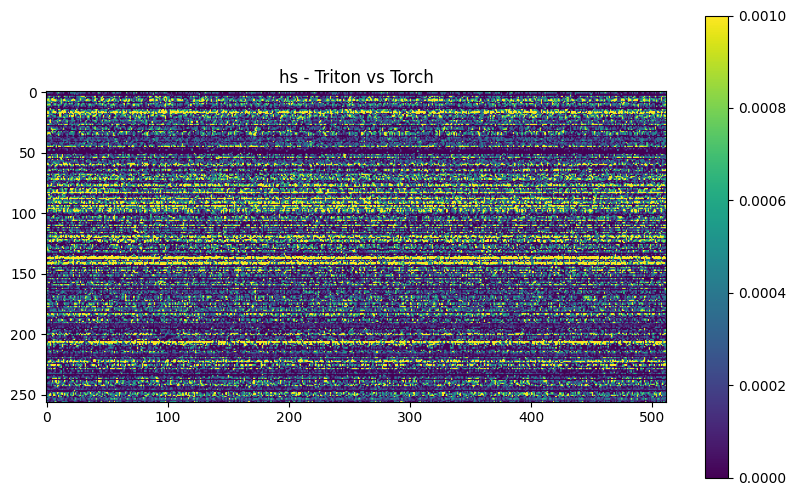

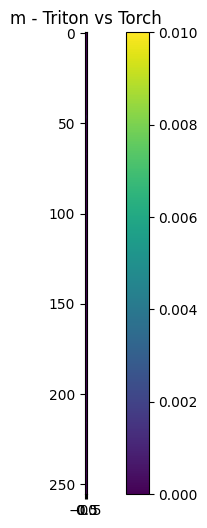

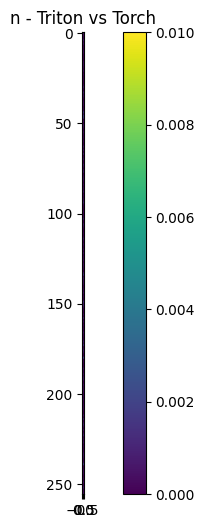

In [20]:
vmax = 0.001
# TODO compare to hs_pt & hs_pt_half (float32 & float16)
# the errors when comparing to hs_pt are larger than when comparing to hs_pt_half, why?
fig = plot_numerical_diffs_single(hs_half, hs_pt_half, "hs - Triton vs Torch", vmax=vmax)

fig = plot_numerical_diffs_single(m_half.unsqueeze(-1), m_pt_half, "m - Triton vs Torch", vmax=0.01)

fig = plot_numerical_diffs_single(n_half.unsqueeze(-1), n_pt_half, "n - Triton vs Torch", vmax=0.01)

In [21]:
igs_half.stride(0), igs_half.stride(1), igs_half.stride(2)

(256, 256, 1)

In [22]:
bool(3 & 2)

True

In [23]:
torch.ones(4)[:, None]

tensor([[1.],
        [1.],
        [1.],
        [1.]])

## Measure Performance

In [24]:
warmup = 100
rep = 1000

BATCH, H, HEAD_DIM = 2, 8, 128
N_CTX = 1024
dtype = torch.float16
device = torch.device("cuda:0")
q = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
k = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
v = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
ig = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
fg = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

In [25]:
mlstm_pt = mlstm_fw_torch
fn = lambda: mlstm_pt(q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

3.684840202331543

In [26]:
mlstm_pt_compile = torch.compile(mlstm_fw_torch)
fn = lambda: mlstm_pt_compile(q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

1.2889175415039062

In [27]:
mlstm_triton = mlstm_fw
fn = lambda: mlstm_triton(q, k, v, ig, fg)
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_fw.py":195:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_tri

0.40577495098114014

In [28]:
# v1: 0.5681418776512146